# Hands On #4 - Balancing Cart Pole w/Q-learning

## Goal:
* Introduce the CartPole Environment
    * More complex, Continuous
* Implement Q-Learning for digitized CartPole
    * Later we will use function approx and remove the requirement for digitization

## Steps:
1. Get familiar with Cartpole environment
    * np.linspace() and np.digitize() for state space aggregation
2. Program Q Learning
3. Track & Plot Metrics to solve Cart Pole

Reference : 
* Based on Udacity github https://github.com/udacity/deep-reinforcement-learning/tree/master/monte-carlo plus
* My solution for the DQN https://github.com/xsankar/DQN_Navigation/blob/master/Navigation-v2.ipynb
* Kaggle https://www.kaggle.com/sandovaledwin/q-learning-algorithm-for-solving-frozenlake-game/notebook
* Phil Tabor's RL in Motion github https://github.com/philtabor/Reinforcement-Learning-In-Motion/tree/master/Unit-7-The-Cartpole

### 1. Install the required packages

* No esoteric requirements
* You can run them without docker
* pip install -r requirements.txt
* Requirements
 * python 3.6, pytorch, openAI gym, numpy, matplotlib
 * anaconda is easier but not needed
 * Miniconda works fine

### 2. Define imports

python 3, numpy, matplotlib, torch, gym

In [9]:
# General imports
import gym
import PIL # for in-line display of certain environments

import sys
import numpy as np
import random
from collections import namedtuple, deque, defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 2.1. Global Constants and other variables

In [10]:
# Constants Definitions
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
# Number of neurons in the layers of the Q Network
FC1_UNITS = 16
FC2_UNITS = 8
FC3_UNITS = 4
# Store models flag. Store during calibration runs and do not store during hyperparameter search
STORE_MODELS = False

### Work Area

In [11]:
# Work area to quickly test utility functions
import math
import time
from datetime import datetime, timedelta
'''
start_time = time.time()
time.sleep(10)
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
'''
print(math.radians(12))
print(math.radians(-12))

0.20943951023931956
-0.20943951023931956


### 3.0 Create instance & Explore

In [12]:
import gym, PIL
env = gym.make('CartPole-v0')
env.reset()
# array = env.reset()
# ** render doesn't work reliably on a server. Uncomment when running ** locally **
# env.render()
# PIL.Image.fromarray(env.render(mode='rgb_array'))

array([0.02948199, 0.02003764, 0.04221512, 0.02956406])

### This what it will look like
### We don't need the render(). We run it on headless mode and inspect the results
<img src="CartPole_Render.jpg">

### 3.1 Examine the State and Action Spaces

* The state space is continuous, with an observation space of 4 
    * {x,$\dot{x}$,$\theta$, theta_dot}
        * Cart Position,  Cart Velocity, Pole Angle, Pole Velocity at tip
        * The angle, probably, is in radians

The action space, on the contrary is simple viz. 0 = Left, 1 = Right

In [13]:
print(env.observation_space)
print(env.action_space)
act_space = [i for i in range(0,env.action_space.n)]
print(act_space)
# env.unwrapped.get_action_meanings() # AttributeError: 'FrozenLakeEnv' object has no attribute 'get_action_meanings'
print('[ 0 = Left, 1 = Right ]')

Box(4,)
Discrete(2)
[0, 1]
[ 0 = Left, 1 = Right ]


In [14]:
print(dir(env))
print(dir(env.unwrapped))
print('States = ',env.unwrapped.observation_space)
print('Actions = ',env.unwrapped.action_space)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_elapsed_seconds', '_elapsed_steps', '_episode_started_at', '_max_episode_seconds', '_max_episode_steps', '_past_limit', 'action_space', 'class_name', 'close', 'compute_reward', 'env', 'metadata', 'observation_space', 'render', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'action_space', 'cl

In [15]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

### 4. Test the environment with Random Action

In [16]:
for i_episode in range(3):
    state = env.reset()
    tot_reward = 0
    steps = 0
    while True:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        print('[',state,']','->', action,' : [',next_state,']', 'R=',reward)
        # env.render()
        tot_reward += reward
        steps += 1
        if done:
            print('Episode {:d} finished after {:d} steps with a Total Reward = {:.0f}'.
                  format(i_episode+1,steps, tot_reward))
            break
        else:
            state = next_state
# Pole angle +/-12 degrees, Cart Pos +/- 2.4 or 200 steps
# Cart Pos, Velocity, Pole Angle, Velocity
# 12 degrees = .2094 radians

[ [-0.04283321  0.01461015  0.03693223 -0.0010063 ] ] -> 1  : [ [-0.04254101  0.20918351  0.03691211 -0.28181171] ] R= 1.0
[ [-0.04254101  0.20918351  0.03691211 -0.28181171] ] -> 1  : [ [-0.03835734  0.40376004  0.03127587 -0.56262799] ] R= 1.0
[ [-0.03835734  0.40376004  0.03127587 -0.56262799] ] -> 0  : [ [-0.03028214  0.20821349  0.02002331 -0.260258  ] ] R= 1.0
[ [-0.03028214  0.20821349  0.02002331 -0.260258  ] ] -> 1  : [ [-0.02611787  0.40304396  0.01481815 -0.54655867] ] R= 1.0
[ [-0.02611787  0.40304396  0.01481815 -0.54655867] ] -> 0  : [ [-0.01805699  0.20771698  0.00388698 -0.24924399] ] R= 1.0
[ [-0.01805699  0.20771698  0.00388698 -0.24924399] ] -> 1  : [ [-0.01390265  0.40278321 -0.0010979  -0.54069835] ] R= 1.0
[ [-0.01390265  0.40278321 -0.0010979  -0.54069835] ] -> 1  : [ [-0.00584698  0.59792058 -0.01191187 -0.83372701] ] R= 1.0
[ [-0.00584698  0.59792058 -0.01191187 -0.83372701] ] -> 1  : [ [ 0.00611143  0.79320324 -0.02858641 -1.13013223] ] R= 1.0
[ [ 0.00611143  

## Q Learning
### Let us implement the Basic Q-Learning Algorithm
<img src='../Qlearning_Alg.png'>

### Step 1 : Define policies

## $\epsilon$-Greedy

<img src="../e_greedy.png" >

In [17]:
def choose_e_greedy_action(env,Q,state,epsilon,nA):
    action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
    return action

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

### We need to convert the sontinuous state space to discrete

In [18]:
#discretize the spaces
poleThetaSpace = np.linspace(-0.20943951, 0.20943951, 10)
poleThetaVelSpace = np.linspace(-4, 4, 10)
cartPosSpace = np.linspace(-2.4, 2.4, 10)
cartVelSpace = np.linspace(-4, 4, 10)

def getState(observation):
    cartX, cartXdot, cartTheta, cartThetadot = observation
    cartX = int(np.digitize(cartX, cartPosSpace))
    cartXdot = int(np.digitize(cartXdot, cartVelSpace))
    cartTheta = int(np.digitize(cartTheta, poleThetaSpace))
    cartThetadot = int(np.digitize(cartThetadot, poleThetaVelSpace))

    return (cartX, cartXdot, cartTheta, cartThetadot)

In [19]:
# uses global variavle env
def q_learning(n_episodes=2000, max_t=1000, 
               epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.9995, # 0.995 gets to min by 1000 episodes
               alpha=0.01, gamma=1.0):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        epsilon_start (float): starting value of epsilon, for epsilon-greedy action selection
        epsilon_end (float): minimum value of epsilon
        epsilon_decay (float): multiplicative factor (per episode) for decreasing epsilon
        alpha = step-size parameter
        gamma = discount rate
    """
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(num_actions))
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    epsilon = epsilon_start            # initialize epsilon
    has_seen_13 = False
    max_score = 0
    # loop over episodes
    for i_episode in range(1, n_episodes+1):
        score = 0
        max_steps = 0
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, n_episodes), end="")
            sys.stdout.flush()
        
        s_t = env.reset()
        a_t = choose_e_greedy_action(env,Q,getState(s_t),epsilon,num_actions)
        t = 0
        while True:
            s_t_d = getState(s_t)
            # state, reward, done, info = env.step(action)
            s_t_1, reward, done, prob = env.step(a_t)
            # print(state,reward,done, prob)
            s_t_1_d = getState(s_t_1) # Digitize state
            a_t_1 = choose_e_greedy_action(env,Q,s_t_1_d,epsilon,num_actions)
            best_a = np.argmax(Q[s_t_1_d])
            Q[s_t_d][a_t] = Q[s_t_d][a_t] + alpha * (reward + gamma*(Q[s_t_1_d][best_a]) - Q[s_t_d][a_t])
            a_t = a_t_1
            s_t = s_t_1
            score += reward
            max_steps += 1
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        epsilon = max(epsilon*epsilon_decay, epsilon_min) # decrease epsilon
        print('\rEpisode : {}\tAverage Score : {:5.2f}\tMax_steps : {}\teps : {:5.3f}\tMax.Score : {:5.3f}'.\
              format(i_episode, np.mean(scores_window),max_steps,epsilon,max_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode : {}\tAverage Score : {:5.2f}\tMax_steps : {}\teps : {:5.3f}\tMax.Score : {:5.3f}'.\
                  format(i_episode, np.mean(scores_window),max_steps,epsilon,max_score))
        if (np.mean(scores_window)>=195.0) and (not has_seen_13):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.\
                  format(i_episode-100, np.mean(scores_window)))
            # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            has_seen_13 = True
        if score > max_score:
            max_score = score
    return scores, Q

Episode : 100	Average Score : 23.28	Max_steps : 22	eps : 0.951	Max.Score : 76.000
Episode : 200	Average Score : 26.34	Max_steps : 23	eps : 0.905	Max.Score : 98.000
Episode : 300	Average Score : 25.10	Max_steps : 16	eps : 0.861	Max.Score : 98.000
Episode : 400	Average Score : 24.75	Max_steps : 16	eps : 0.819	Max.Score : 98.000
Episode : 500	Average Score : 24.74	Max_steps : 29	eps : 0.779	Max.Score : 98.000
Episode : 600	Average Score : 22.63	Max_steps : 14	eps : 0.741	Max.Score : 98.000
Episode : 700	Average Score : 26.43	Max_steps : 25	eps : 0.705	Max.Score : 98.000
Episode : 800	Average Score : 23.04	Max_steps : 27	eps : 0.670	Max.Score : 98.000
Episode : 900	Average Score : 25.26	Max_steps : 21	eps : 0.638	Max.Score : 121.000
Episode : 1000	Average Score : 26.06	Max_steps : 19	eps : 0.606	Max.Score : 121.000
Episode : 1100	Average Score : 26.75	Max_steps : 21	eps : 0.577	Max.Score : 121.000
Episode : 1200	Average Score : 25.79	Max_steps : 28	eps : 0.549	Max.Score : 121.000
Episode :

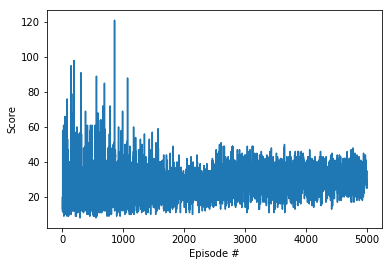

Max Score 121.000000 at 856
Percentile [25,50,75] : [21. 27. 33.]
Variance : 83.717


In [20]:
# obtain the estimated optimal policy and corresponding action-value function
start_time = time.time()
scores, QVal = q_learning(n_episodes=5000)
# env.close() # Close the environment
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print('Max Score {:2f} at {}'.format(np.max(scores), np.argmax(scores)))
print('Percentile [25,50,75] : {}'.format(np.percentile(scores,[25,50,75])))
print('Variance : {:.3f}'.format(np.var(scores)))

In [ ]:
for k,v in QVal.items():
    print('k={},v={}'.format(k,v))

In [22]:
# Construct the estimated optimal policy
QPolicy={}
for k,v in QVal.items():
    QPolicy[k] = [0] * num_actions
    QPolicy[k][np.argmax(QVal[k])] = 1

### Points to Ponder
1. Like our earlier lab we can decay $\epsilon$ in different ways
2. Even after 30,000 episodes it doesn't solve the environment.
    * There is opportunity for tweaking

## Test our policy

In [23]:
for i_episode in range(2): 
    state = env.reset()
    tot_reward = 0
    steps = 0
    while True:
        if getState(state) in QPolicy:
            probs = QPolicy[getState(state)]
        else:
            print(".")
            probs = [1.0/num_actions] * num_actions
        action = np.random.choice(np.arange(num_actions), p=probs)
        next_state, reward, done, info = env.step(action)
        # print('[',state,']',' -> ', action,' = [',next_state,']', reward)
        tot_reward += reward
        steps += 1
        if done:
            print('Episode {:d} finished after {:d} steps with a Total Reward = {:.0f}'.
                  format(i_episode+1,steps, tot_reward))
            break
        else:
            state = next_state

Episode 1 finished after 29 steps with a Total Reward = 29
Episode 2 finished after 25 steps with a Total Reward = 25


In [24]:
env.close()

## _That's all Folks !_